In [1]:
import pandas as pd
import numpy as np 
from Custom_Libraries import portfolio_analyser

In [2]:
def Portfolio_Optimiser(User_ID, risk_free_return, target_risk_range, iter_count):
    # Returns optimised portfolio weithts that maximise return for a given range of risk.
    # User_ID: Unique user ID - ETF selection is made based on this value.
    # risk_free_return: Risk free return value used in sharpe ratio calculation (redundant).
    # target_risk_range: A list containing the upper and lower risk thresholds.
    # iter_count: Number of iterations used in monte-carlo simulation.
    # ----------> Higher iter_count improves accuracy at the cost of increased program run times. 
    
    ETFs_Selection = pd.read_csv('ETF_Recommendation_' + User_ID +'.csv').Tickers.values # Reading ETFs that are recommended to the user.
    ETF_data = pd.read_csv('ETF_df.csv')[ETFs_Selection] # Reading selected ETF data.
    ETF_df_returns = ETF_data.pct_change() # Calculating ETF returns. Calculated as: ((val[1] - val[0])/val[0]).
    cov_matrix = ETF_df_returns.cov() # Generating the covariance matrix. 
    
    # Instantiating empty lists to interate through monte-carlo simulations.
    returns = [] 
    risk = []
    weights_list = []
    
    w_len = len(ETF_df_returns.columns) # Counting the number of recommended ETFs.
    
    for i in range(iter_count): # loop for monte-carlo simulation.
        weights = np.random.dirichlet(np.ones(w_len)) # Generating a random set of weights whose sum add up to 1.
        portfolio = portfolio_analyser(weights, ETF_df_returns, risk_free_return, cov_matrix) # Estimating portfolio statistis for the current set of random weights.
        
        if portfolio[1] > target_risk_range[0] and portfolio[1] < target_risk_range[1]: # Checking if the current portfolio satisfy the required risk limits.
            returns.append(portfolio[0]) # Storing current portfolio returns as it satisfies the required risk limits
#             risk.append(portfolio[1])
            risk.append(target_risk_range) # Storing current portfolio risk limits as they satisfy the required risk limits
            weights_list.append(weights) # Storing current portfolio weights as they satisfy the required risk limits

    portfolio_dict = {'returns': returns, 'risk': risk, 'weights': weights_list} # Storing all the portfolios that statify the required risk limits in a dictionary.
    portfolio_options = pd.DataFrame(portfolio_dict) # Converting the portfolio dictionary to a data frame.
    portfolio_options_sorted = portfolio_options.sort_values('returns', ascending=False) # Sorting the portfolio data frame by returns in descending order.
    if len(portfolio_options_sorted) > 0: # Checking if atleast one portfolio is found for the selected input conditions.
        returns_max_weights = portfolio_options_sorted.iloc[0,2] # Portfolio weights the produce maximum return.
        returns_min_weights = portfolio_options_sorted.iloc[-1,2] # Portfolio weights the produce minimum return.
        portfolio_results = {'target_risk_range': [target_risk_range], 'returns_max_weights': [returns_max_weights], 'returns_min_weights': [returns_min_weights]} # Storing the required portfolio weights in a dictionary.
        return portfolio_results # Returning the required portfolio weights.
    else: # No portfoio is found for the selected input conditions.
        print("Portfolio generation within the risk thresholds is unsuccessful!")

In [3]:
Portfolio_Optimiser('User_750', 0.05, [0.18, 0.2], 10000)

{'target_risk_range': [[0.18, 0.2]],
 'returns_max_weights': [array([0.71273051, 0.1775716 , 0.00353743, 0.08418377, 0.02197669])],
 'returns_min_weights': [array([0.52772501, 0.03560655, 0.38674613, 0.03798325, 0.01193906])]}

In [4]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import datetime 
import yfinance as yf

In [5]:
User_ID = 'User_750'
ETFs_Selection = pd.read_csv('ETF_Recommendation_' + User_ID +'.csv').Tickers.values
ETF_data = pd.read_csv('ETF_df.csv')[ETFs_Selection]  
ETF_df_returns = ETF_data.pct_change()
cov_matrix = ETF_df_returns.cov()

In [6]:
returns = []
risk = []
sharpe_ratio = []
weights_list = []
w_len = len(ETF_df_returns.columns)
risk_free_return = 0.05
iter = 50000
status_count = list(range(0, iter, (iter - 0) // 99))
for i in range(iter):
    if i in status_count:
        clear_output(wait=True)
        print("{}% complete!".format(int(i*100/iter)))      
    weights = np.random.dirichlet(np.ones(w_len))
    portfolio = portfolio_analyser(weights, ETF_df_returns, risk_free_return, cov_matrix)    
    returns.append(portfolio[0])
    risk.append(portfolio[1])
    sharpe_ratio.append(portfolio[2])
    weights_list.append(weights)
clear_output(wait=True)
portfolio_dict = {'returns': returns, 'risk': risk, 'sharpe_ratio': sharpe_ratio, 'weights': weights_list}
portfolio_options = pd.DataFrame(portfolio_dict)
# portfolio_options

99% complete!


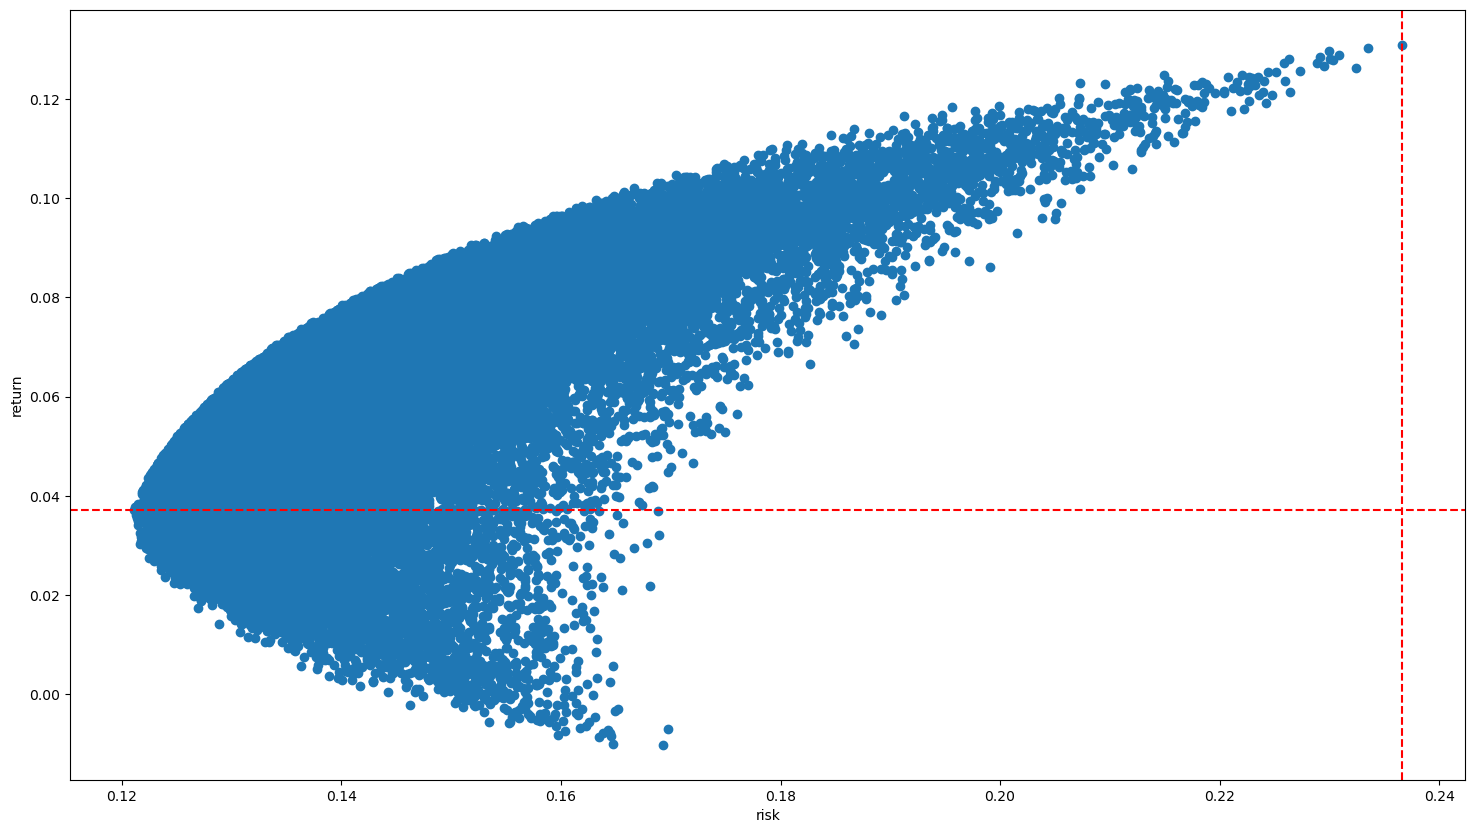

In [7]:
returns_range = portfolio_options['returns'].quantile([0.98, 1])
risk_range = portfolio_options['risk'].quantile([0, 0.5])

plt.figure(figsize=(18,10))
plt.scatter(portfolio_options['risk'], portfolio_options['returns'])
plt.axhline(y=portfolio_options['returns'][portfolio_options['risk'].idxmin()], color='r', linestyle='--')
plt.axvline(x=portfolio_options['risk'][portfolio_options['returns'].idxmax()], color='r', linestyle='--')
plt.xlabel('risk')
plt.ylabel('return')
plt.show()